In [1]:
import argparse
import datetime
import random
import time
from pathlib import Path
import os, sys
sys.path.append("C:/Users/piyalong/CrowdCounting-P2PNet/")
import torch
import torchvision.transforms as standard_transforms
import numpy as np

from PIL import Image
import cv2
from crowd_datasets import build_dataset
# from engine import *
# from models import build_model
import os
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from shapely.geometry import Point as P
from shapely.geometry.polygon import LinearRing, Polygon
torch.cuda.empty_cache() 
import cv2
import json
import pandas as pd

In [2]:
def study_zone(im_path,json_path):
    
    img = cv2.imread(im_path)
    studyzones=json_path

    pixelzones = {}
    with open(studyzones, 'r') as json_file:
        zones = json.load(json_file)
        for each in (zones['shapes']):
            pixelzones.update({each['label']:each['points']})
    for zonename,check_zone in pixelzones.items():
        pts = np.array(check_zone, np.int32)
        for i,checkline in enumerate(check_zone):
            p1,p2 = (check_zone[i],check_zone[i-1])
        pts = pts.reshape((-1, 1, 2))
        im=cv2.polylines(img,[pts],True,(0,255,255),10)
        
        im=cv2.putText(img,zonename,tuple((np.array([int(x) for x in p1])+np.array([int(x) for x in p2]))//2),cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 2)

        
    plt.imshow(im)
    return pixelzones

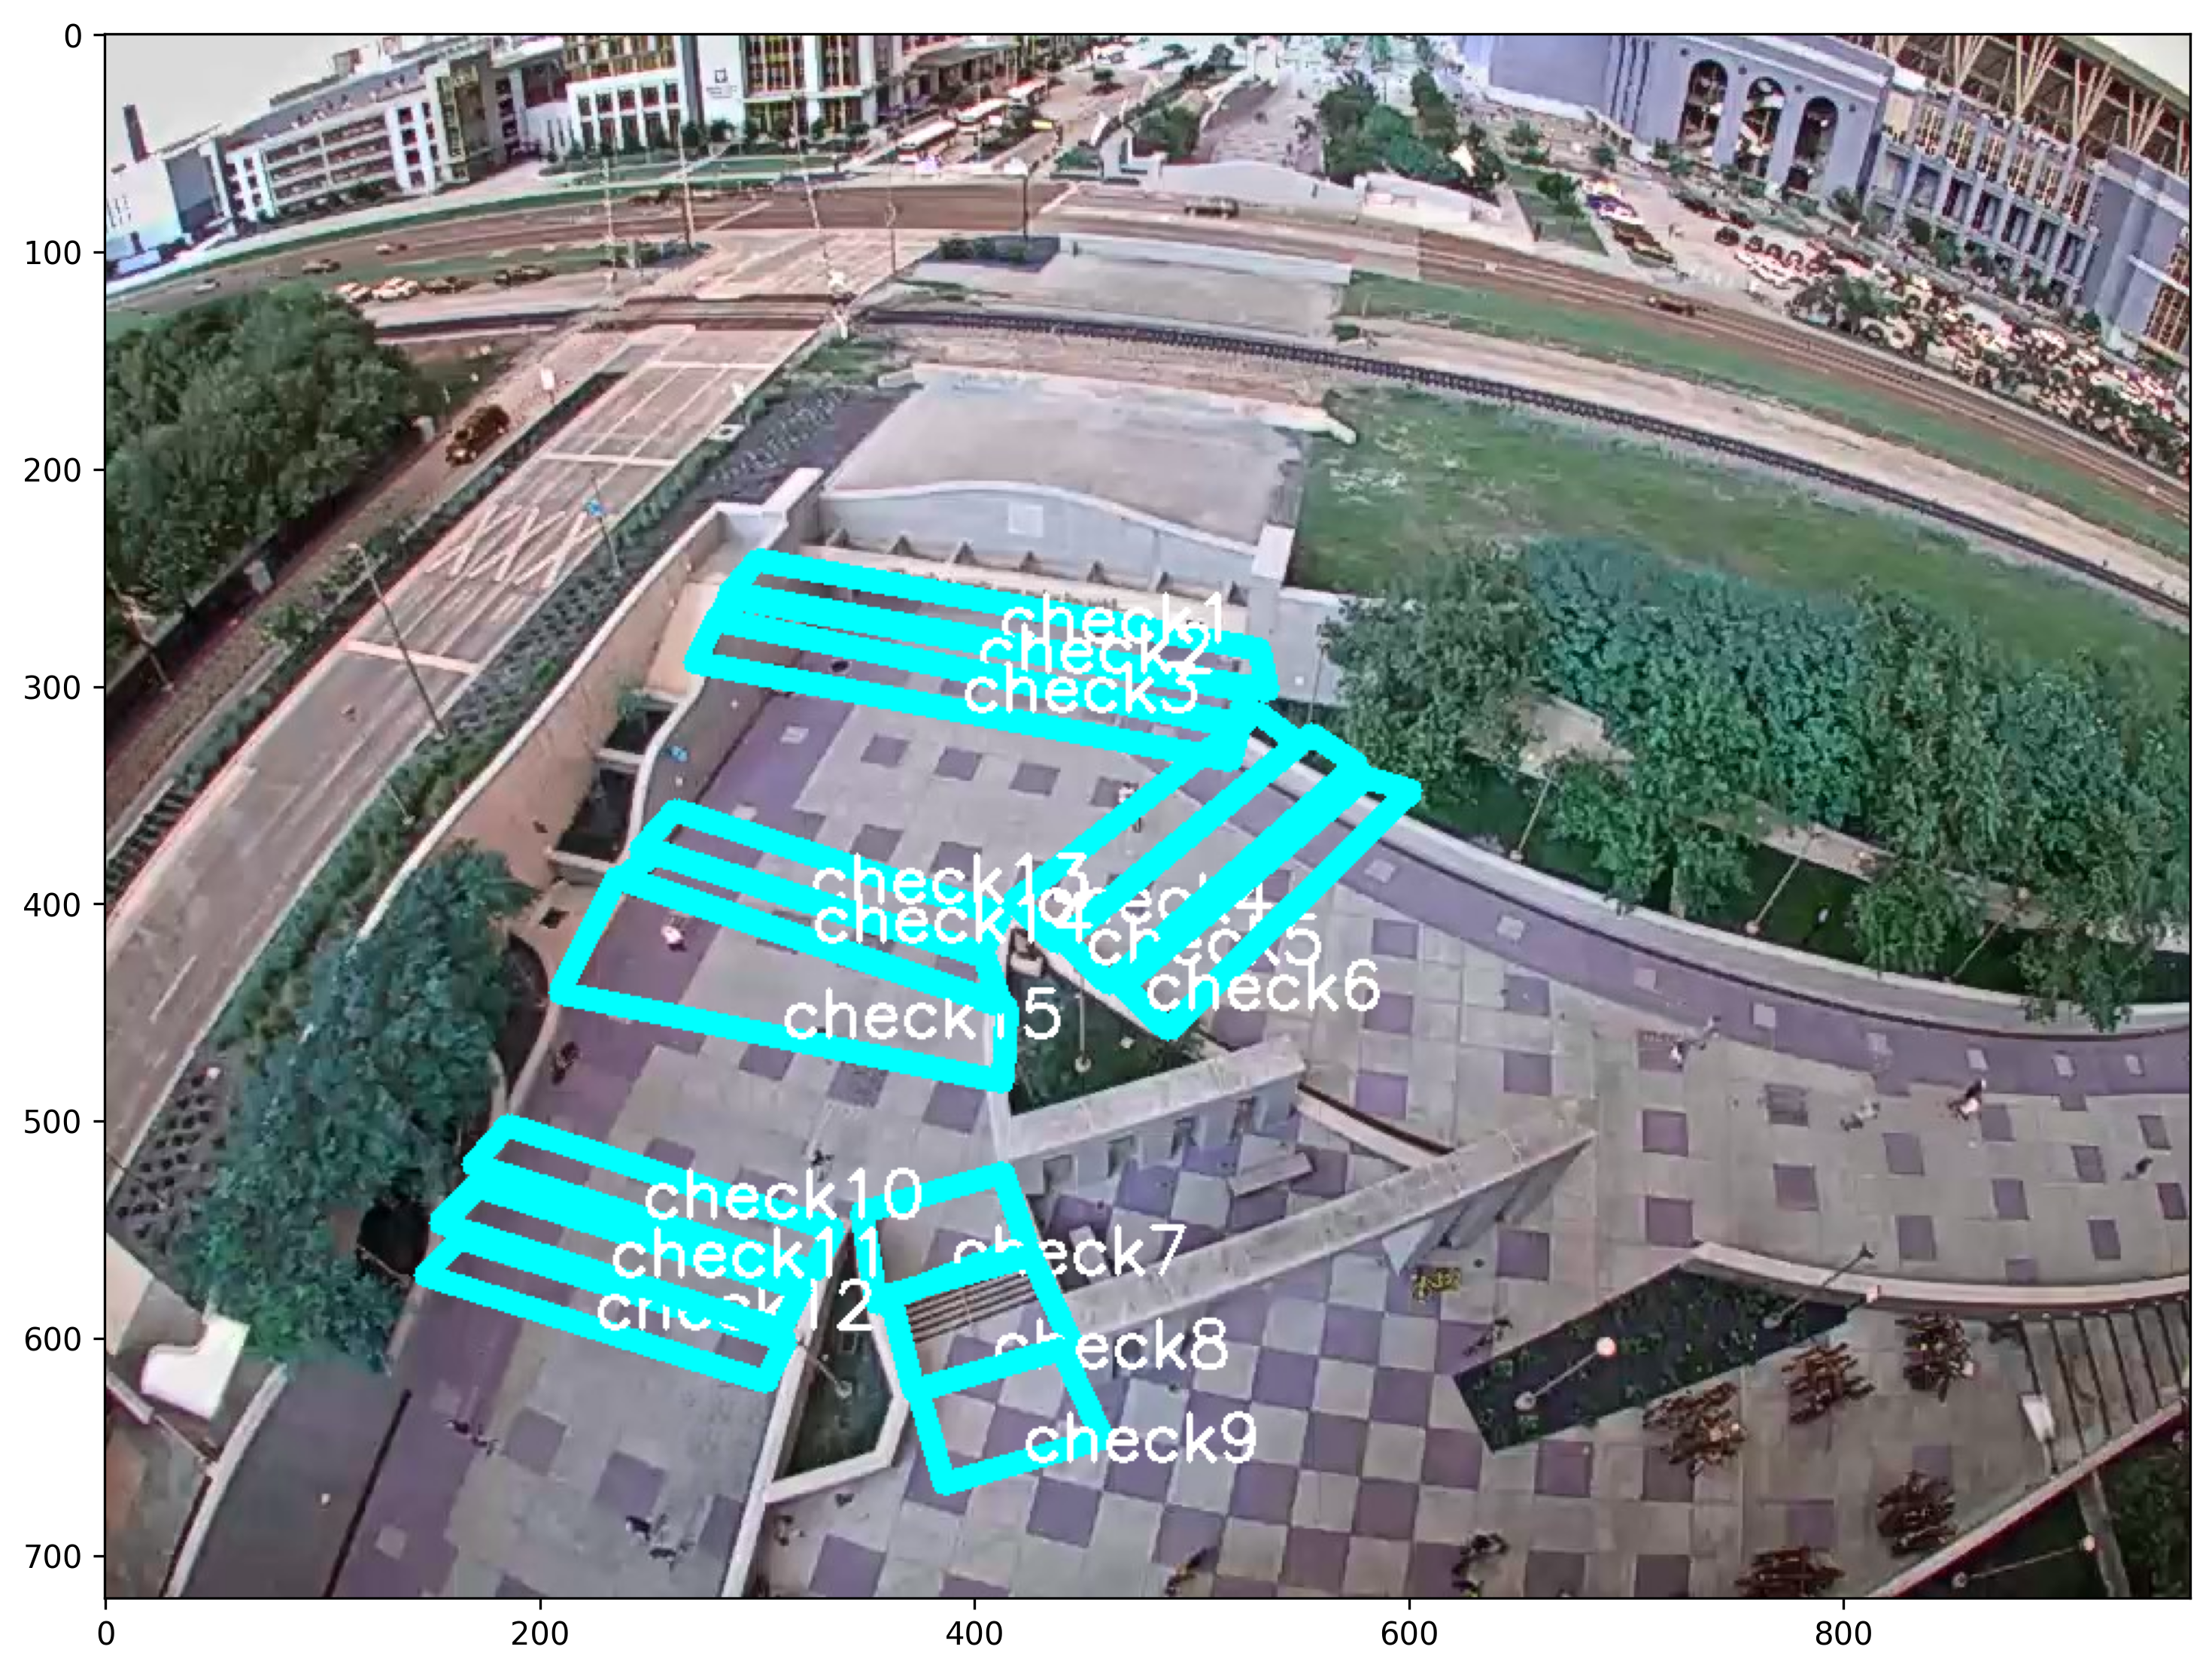

In [3]:
fig, axs = plt.subplots(1,1,figsize=(16,9),dpi=300)

pixelzones = study_zone('C:/Users/piyalong/Pictures/WCG _ P6 NE Corner UFO - Camera - 01-2022-09-10_17h00min00s000ms_Moment.jpg',
                        'C:/Users/piyalong/Pictures/WCG _ P6 NE Corner UFO - Camera - 01-2022-09-10_17h00min00s000ms_Moment.json')

In [4]:
class Point:
	def __init__(self,x,y):
		self.x = x
		self.y = y

def ccw(A,B,C):
	return (C.y-A.y)*(B.x-A.x) > (B.y-A.y)*(C.x-A.x)

def intersect(A,B,C,D):
	return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def check_cross(checkline, traj_line):
    
    previous_x,previous_y = traj_line[1][0],traj_line[1][1]
    next_x,next_y = traj_line[0][0],traj_line[0][1]
    
    return intersect(Point(previous_x,previous_y), Point(next_x,next_y),Point(checkline[0][0],checkline[0][1]),Point(checkline[1][0],checkline[1][1]))


In [5]:
fps=15

In [6]:
def read_detection(folder):
    total_leaving = {i:{} for i in pixelzones.keys()}

    total_entering = {i:{}  for i in pixelzones.keys()}

    fps=15
    
    for file in os.listdir(folder):
        if not file.endswith('.npy'):continue
        if 'Corner' not in file:continue
        data=np.load(folder+file,allow_pickle=True)

        print(file)

        for ID in  data.item():
            every_trace = data.item()[ID]
            txt=file
            date = txt[txt.find("min")-16:txt.find("min")-6]
            hrs = txt[txt.find("min")-5:txt.find("min")-3]
            minute = txt[txt.find("min")-2:txt.find("min")]
            second = txt[txt.find("min")+3:txt.find("min")+5]
            t = pd.to_datetime(date+' '+hrs+':'+minute+':'+second)
            for x ,trace in enumerate(every_trace):
                if x <=1 :continue
                traj_line = [every_trace[x-1],every_trace[x]]
                first_point = P(traj_line[0])
                last_point = P(traj_line[1])
                frame = trace[-1]
                current_t = t + datetime.timedelta(0,frame/fps)
                for zonename,check_zone in pixelzones.items():
                    zone = Polygon(check_zone)
                    for i in range(0,len(check_zone)):
                        checkline = [check_zone[i],check_zone[i-1]]

                        if check_cross(checkline,traj_line) :
                            if  zone.contains(last_point,):
                                total_entering[zonename].update({current_t:1})
                            if  zone.contains(first_point):
                                total_leaving[zonename].update({current_t:1})

    interval='1min'

    # df_leave = pd.read_csv('Outside_total_leave.csv',index_col = 0, parse_dates=True)
    df_leave = pd.DataFrame(total_leaving)
    # df_leave.to_csv('Outside_total_leave.csv')

    # df_enter = pd.read_csv('Outside_total_enter.csv',index_col = 0, parse_dates=True)
    df_enter = pd.DataFrame(total_entering)
    # df_enter.to_csv('Outside_total_enter.csv')


    to_plot = (df_leave.resample(interval).agg('sum')+df_enter.resample(interval).agg('sum'))/2


    return to_plot

In [ ]:
data.item()[i]

In [ ]:
appastate = read_detection("D:/Appa State/")
appastate.to_csv('AppaState_UFO.csv')


In [ ]:
appastate[['check1','check2','check3']].mean(axis=1).plot()

In [ ]:
miami = read_detection('E:/2022 season/Miami/SEP 17 (SAT) 8_00 PM  (#16) MIAMI/')
miami.to_csv('Miami_UFO.csv')

In [ ]:
miami.set_index('Unnamed: 0')

In [ ]:
miami.set_index('Unnamed: 0')


<AxesSubplot:xlabel='Time'>

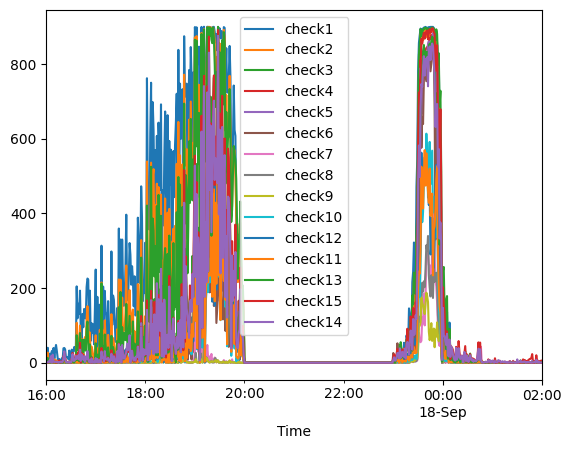

In [8]:
miami = pd.read_csv('Miami_UFO.csv',parse_dates=['Unnamed: 0'])
miami=miami.set_index('Unnamed: 0')
miami.index.name='Time'
miami.plot()


<AxesSubplot:xlabel='Time'>

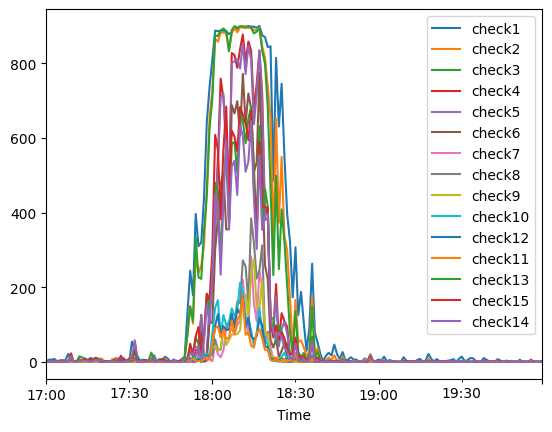

In [9]:

appastate = pd.read_csv('AppaState_UFO.csv',parse_dates=['Unnamed: 0'])
appastate=appastate.set_index('Unnamed: 0')
appastate.index.name='Time'

appastate.plot()

In [10]:
mask_pre = miami.index<'2022-09-17 22:00:00' 

In [11]:
miami_pregame = miami[['check1','check2','check3']][mask_pre]

Text(0.5, 1.0, 'Pre-game Total (P) 72774')

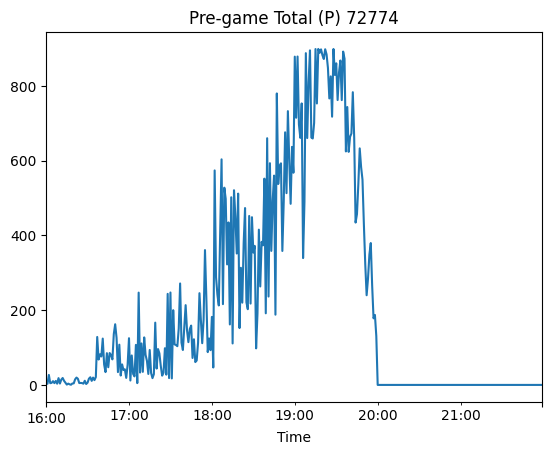

In [12]:
# miami_pregame.mean(axis=1).sum()
miami_pregame.mean(axis=1).plot()
plt.title('Pre-game Total (P) '+str(round(miami_pregame.mean(axis=1).to_numpy().sum())))


Text(0.5, 1.0, 'Post-game Total (P) 28058')

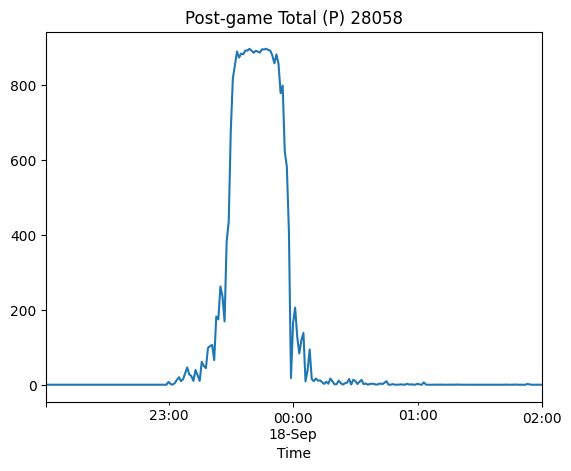

In [13]:
mask_post = miami.index>'2022-09-17 22:00:00' 
miami_postgame = miami[['check1','check2','check3']][mask_post]
# miami_pregame = miami[mask_pre]
miami_postgame.mean(axis=1).plot()
plt.title('Post-game Total (P) '+str(round(miami_postgame.mean(axis=1).to_numpy().sum())))

In [14]:
miami[mask_pre].sum(axis=0)

check1     91245.0
check2     67885.5
check3     59191.5
check4     17619.0
check5     14656.5
check6     10564.0
check7      1127.0
check8       371.5
check9       335.0
check10    15259.0
check12    17473.5
check11    15727.0
check13    31274.5
check15    31083.5
check14    28682.0
dtype: float64

In [171]:
miami[mask_post].sum(axis=0)

check1     28894.5
check2     26529.5
check3     28749.0
check4     21692.0
check5     20744.0
check6     18168.0
check7      5224.0
check8      5795.0
check9      3324.5
check10    11445.5
check12    12231.0
check11    11562.5
check13    23372.5
check15    26754.5
check14    22828.0
dtype: float64

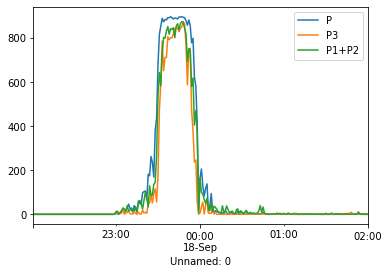

In [70]:
miami[['check1','check2','check3']].mean(axis=1).plot(label='P')
miami[['check4','check5','check6']].mean(axis=1).plot(label='P3')
# miami[['check7','check8','check9']].mean(axis=1).plot(label='P2')
# miami[['check10','check11','check12']].mean(axis=1).plot(label='P1')
miami[['check13','check14','check15']].mean(axis=1).plot(label='P1+P2')
plt.legend()

In [ ]:
miami[['check1','check2','check3']].plot()

In [ ]:
miami[['check4','check5','check6']].plot()

In [ ]:
miami[['check13','check14','check15']].plot()

In [71]:
miami[['check1','check2','check3']].mean(axis=1).sum()

28057.666666666668

In [72]:
miami[['check4','check5','check6']].mean(axis=1).sum()

20201.333333333336

In [73]:
miami[['check13','check14','check15']].mean(axis=1).sum()

24318.333333333332

In [111]:
df=miami
total = []

28058

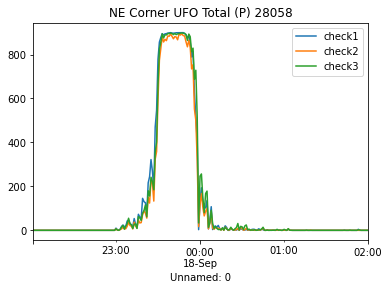

In [112]:
P = df[['check1','check2','check3']]
P.plot()
p=round(P.mean(axis=1).to_numpy().sum())
plt.title('NE Corner UFO Total (P) '+str(round(P.mean(axis=1).to_numpy().sum())))
total.append(round(P.mean(axis=1).to_numpy().sum()))
p

20201.333333333336

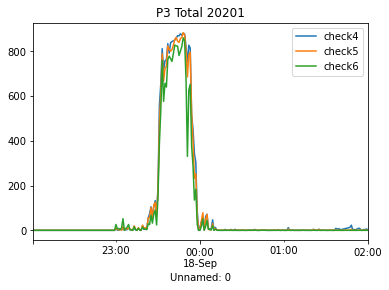

In [113]:
P3 = df[['check4','check5','check6']]
P3.plot()
p3 = P3.mean(axis=1).to_numpy().sum()
plt.title('P3 Total '+str(round(p3)))
total.append(round(P3.mean(axis=1).to_numpy().sum()))
p3

24318.333333333332

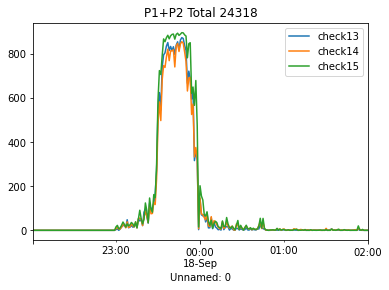

In [114]:
P1P2  = df[['check13','check14','check15']]
P1P2 .plot()

p1p2 = P1P2.mean(axis=1).to_numpy().sum()

plt.title('P1+P2 Total '+str(round(p1p2)))

total.append(round(P1P2.mean(axis=1).to_numpy().sum()))

p1p2

4781.166666666667

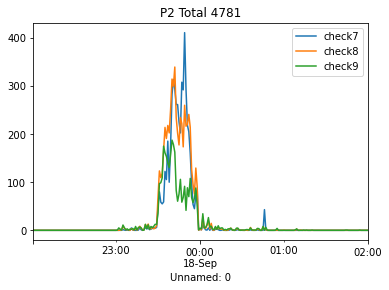

In [115]:
P2 = df[['check7','check8','check9']]
p2 = P2.mean(axis=1).to_numpy().sum()
P2.plot()
plt.title('P2 Total '+str(round(p2)))
total.append(round(P2.mean(axis=1).to_numpy().sum()))

p2

11746.333333333332

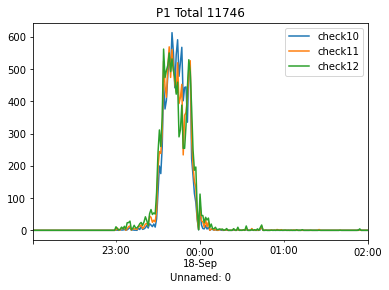

In [116]:
P1 = df[['check10','check11','check12']]
P1.plot()
p1 = P1.mean(axis=1).to_numpy().sum()
plt.title('P1 Total '+str(round(p1)))
total.append(round(P1.mean(axis=1).to_numpy().sum()))

p1

In [117]:
total

[28058, 20201, 24318, 4781, 11746]

In [97]:
p2+p1+p3

18831.666666666664

In [ ]:
p1

In [ ]:
p1p2 